In [1]:
!pip install scikit-learn

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import shutil
import glob
import yaml
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import ultralytics
from ultralytics import YOLO

/var/folders/gp/f80ywcw94q97zw8fbj8_ccjh0000gn/T/ipykernel_2305/3999758498.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#https://www.kaggle.com/datasets/andrewmvd/face-mask-detection 데이타셋 다운로드
#PASCAL VOC 어노테이션 파일들의 경로 생성
directory='./datasets'#케글에서 다운받은 데이타셋 사용(폴더명은 반드시 datasets로)

annotation_directory=os.path.join(directory,'annotations')

annotations = list(glob.glob(r'{}/*.xml'.format(annotation_directory)))
annotations

['./datasets/annotations/maksssksksss299.xml',
 './datasets/annotations/maksssksksss528.xml',
 './datasets/annotations/maksssksksss272.xml',
 './datasets/annotations/maksssksksss514.xml',
 './datasets/annotations/maksssksksss500.xml',
 './datasets/annotations/maksssksksss266.xml',
 './datasets/annotations/maksssksksss716.xml',
 './datasets/annotations/maksssksksss702.xml',
 './datasets/annotations/maksssksksss845.xml',
 './datasets/annotations/maksssksksss689.xml',
 './datasets/annotations/maksssksksss851.xml',
 './datasets/annotations/maksssksksss138.xml',
 './datasets/annotations/maksssksksss662.xml',
 './datasets/annotations/maksssksksss104.xml',
 './datasets/annotations/maksssksksss110.xml',
 './datasets/annotations/maksssksksss676.xml',
 './datasets/annotations/maksssksksss20.xml',
 './datasets/annotations/maksssksksss448.xml',
 './datasets/annotations/maksssksksss34.xml',
 './datasets/annotations/maksssksksss306.xml',
 './datasets/annotations/maksssksksss460.xml',
 './datasets/an

In [4]:
#PASCAL VOC형태의 데이타셋(레이블링 데이타(경계상자정보등))을 YOLO 모델버전으로 변경하기 위한 전처리
#클래스명은 어노테이션 파일인 xml의 name요소명과 일치시키자
classes ={
    'with_mask' : 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2
}
#PASCAL VOC데이타 구조를 YOLO모델 구조로 변경하기 위한 딕셔너리 생성
pascal_data ={
    'filename':[], #.xml의 filename요소
    'label':[],#.xml의 name요소
    'class_id':[],#위의 class_id
    'width':[],#동일
    'height':[],#동일
    'bboxes':[]#.xml의bndbox요소    
}

In [5]:
#어노테이션 파일인 xml들에서 정보를 추출해서 위에 정의한 pascal_data에 저장하기
for annotation in annotations:#어노테이션 파일(.xml)경로들
    tree = ET.parse(annotation)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text
        
        bbox = []
        # bndbox 는 xmin, ymin, xmax, ymax
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')        
        pascal_data['filename'].append(filename)
        pascal_data['width'].append(int(size.find('width').text))
        pascal_data['height'].append(int(size.find('height').text))
        pascal_data['label'].append(label)
        pascal_data['class_id'].append(classes[label])
        pascal_data['bboxes'].append(bbox) 

In [6]:
#데이타프레임으로 확인:853이미지에 4072개의 객체를 레이블링함
df_data = pd.DataFrame(pascal_data)
df_data.head()

,filename,label,class_id,width,height,bboxes
0,maksssksksss299.png,without_mask,2,301,400,"[62, 194, 160, 320]"
1,maksssksksss528.png,without_mask,2,301,400,"[43, 169, 149, 308]"
2,maksssksksss272.png,mask_weared_incorrect,1,275,400,"[48, 107, 218, 304]"
3,maksssksksss514.png,with_mask,0,400,267,"[28, 78, 43, 99]"
4,maksssksksss514.png,with_mask,0,400,267,"[160, 66, 176, 83]"


In [7]:
#결측치 파악
df_data.isnull().sum()

filename    0
label       0
class_id    0
width       0
height      0
bboxes      0
dtype: int64

In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   class_id  4072 non-null   int64 
 3   width     4072 non-null   int64 
 4   height    4072 non-null   int64 
 5   bboxes    4072 non-null   object
dtypes: int64(3), object(3)
memory usage: 191.0+ KB


In [9]:
#각 클래스별 빈도수
df_data.label.value_counts()

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

In [10]:
#YOLO 모델의 바운딩 박스 포맷
#(중심 x 좌표, 중심 y 좌표, 너비, 높이)
#PASCAL VOC 포맷을 YOLO모델 포맷으로 변경하는 함수
def pascal_to_yolo_bbox(bbox, w, h):
    '''
    bbox :[xmin,ymin,xmax,ymax]
    w:이미지의 width
    h:이미지의 height
    '''
    #w:512	h:366	[79, 105, 109, 142]
    x_min, y_min, x_max, y_max = bbox#PASCAL VOC포맷    
    #YOLO 모델 포맷 으로 변경(x_center, y_center, width, heigh):정규화된 Offset 데이타이다
    #https://lohithmunakala.medium.com/bounding-box-formats-for-models-like-yolo-ssd-rcnn-fast-rcnn-faster-rcnn-807be7721527
    #[79, 105, 109, 142]
    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h
    
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return [x_center, y_center, width, height]

In [11]:
#train/test/valid폴더 생성
train_images_dir = "./datasets/train/images"
train_labels_dir = "./datasets/train/labels"
test_images_dir = "./datasets/test/images"
test_labels_dir = "./datasets/test/labels"
valid_images_dir = "./datasets/valid/images"
valid_labels_dir = "./datasets/valid/labels"

if not os.path.exists(train_images_dir):
    os.makedirs(train_images_dir)
if not os.path.exists(train_labels_dir):
    os.makedirs(train_labels_dir)
if not os.path.exists(test_images_dir):
    os.makedirs(test_images_dir)
if not os.path.exists(test_labels_dir):
    os.makedirs(test_labels_dir)
if not os.path.exists(valid_images_dir):
    os.makedirs(valid_images_dir)
if not os.path.exists(valid_labels_dir):
    os.makedirs(valid_labels_dir)

In [12]:
#각 이미지를 해당 폴더로 이동하고 YOLOv8에서 사용할 이미지에 대한 레이블 파일(.yaml) 생성
X_train,X_test=train_test_split(df_data.filename.unique(),test_size=0.1,random_state=42)
X_train,valid = train_test_split(X_train,test_size=0.2,random_state=42)

In [13]:
#datasets/images에 있는 이미지들을 datasets/train/images,datasets/test/images,datasets/valid/images각 디렉토리의
#images폴더로 복사
image_directory=directory+'/images'
def copy_images(images, folder_name):
    for image in images:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

In [14]:
#YOLO모델용 레이블파일(이미지명.txt)를 생성하는 함수
#이미지 파일명과 레이블 파일명이 같아야 한다
#클래스 ID, 중심 x 좌표, 중심 y 좌표, 너비, 높이
def create_yolo_label_file(images, folder_name):
    for image in images:
        filename = image.split('.')[0]#확장자를 제외한 파일명만 추출       
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + filename +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                print('box_text:',bbox_text)
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")

In [15]:
#이미지 복사
copy_images(X_train, train_images_dir)
copy_images(X_test, test_images_dir)
copy_images(valid, valid_images_dir)

In [16]:
#YOLO모델용 레이블파일 생성
create_yolo_label_file(X_train, train_labels_dir)
create_yolo_label_file(X_test, test_labels_dir)
create_yolo_label_file(valid, valid_labels_dir)

box_text: 0.18625 0.7819383259911894 0.1725 0.3568281938325991
box_text: 0.20625 0.3722466960352423 0.1425 0.2422907488986784
box_text: 0.54375 0.4801762114537445 0.1425 0.27312775330396477
box_text: 0.83625 0.32158590308370044 0.1175 0.22026431718061673
box_text: 0.50375 0.2026431718061674 0.0975 0.12334801762114538
box_text: 0.31 0.1104868913857678 0.13 0.21348314606741572
box_text: 0.55 0.5056179775280899 0.075 0.149812734082397
box_text: 0.66625 0.5842696629213483 0.0575 0.11235955056179775
box_text: 0.785 0.7247191011235955 0.055 0.10112359550561797
box_text: 0.845 0.7734082397003745 0.045 0.08614232209737828
box_text: 0.90375 0.8052434456928839 0.0525 0.08239700374531835
box_text: 0.5282392026578073 0.39 0.3122923588039867 0.315
box_text: 0.40863787375415284 0.6325 0.3521594684385382 0.34
box_text: 0.21625 0.19137931034482758 0.0925 0.09310344827586207
box_text: 0.415 0.20862068965517241 0.06 0.09310344827586207
box_text: 0.625 0.17758620689655172 0.06 0.1206896551724138
box_text

In [17]:
#YOLO모델을 커스텀 데이타셋으로 훈련하기 위한 yaml파일 생성
#https://github.com/ultralytics/yolov5/blob/master/data/coco128.yaml 참조
#파이썬 코드로 안하고 위 주소 참조해서 수동으로 직접 작성해도 된다
config_yaml=f'''    
    train: train
    val: valid
    test: test
    nc: {df_data.label.unique().size}
    names:
        0: with_mask
        1: mask_weared_incorrect
        2: without_mask
'''
with open('mask_config.yaml','w',encoding='utf8') as f:
    f.write(config_yaml)

In [18]:
model =YOLO('yolov8s.pt')#사전학습 모델 다운로드

In [19]:
model.train(data='./mask_config.yaml',epochs=2)

New https://pypi.org/project/ultralytics/8.1.47 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.12 🚀 Python-3.11.7 torch-2.2.0 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=./mask_config.yaml, epochs=2, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=Fals

train: Scanning /Users/everyshare/project4/model_train/datasets/train/labels... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<00:00, 1175.43it/s]

train: New cache created: /Users/everyshare/project4/model_train/datasets/train/labels.cache



val: Scanning /Users/everyshare/project4/model_train/datasets/valid/labels... 154 images, 0 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<00:00, 1114.47it/s]

val: New cache created: /Users/everyshare/project4/model_train/datasets/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G       1.83      2.439      1.502        121        640:  56%|█████▋    | 22/39 [04:40<03:38, 12.86s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
        1/2         0G      1.614      1.909       1.33         35        640: 100%|██████████| 39/39 [08:11<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:42<00:00,  8.46s/it]

                   all        154        675      0.521      0.499      0.489       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.208     0.9344      1.055        118        640:  87%|████████▋ | 34/39 [07:22<01:02, 12.50s/it]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
        2/2         0G      1.206      0.933      1.058         31        640: 100%|██████████| 39/39 [08:14<00:00, 12.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:42<00:00,  8.48s/it]

                   all        154        675      0.543      0.607      0.606      0.386



2 epochs completed in 0.298 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.1.12 🚀 Python-3.11.7 torch-2.2.0 CPU (Apple M1 Pro)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]


                   all        154        675      0.541      0.607      0.607      0.386
             with_mask        154        559       0.86        0.9      0.931      0.616
 mask_weared_incorrect        154         19      0.159      0.105      0.124     0.0733
          without_mask        154         97      0.605      0.814      0.766      0.469
Speed: 0.8ms preprocess, 254.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x320797dd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [22]:
#커스텀 데이타로 훈련된 모델 로드
mask_model = YOLO(model='./runs/detect/train/weights/best.pt')

In [23]:
#테스트 경로에 있는 이미지들로 테스트
filenames= glob.glob(test_images_dir+'/*.png',recursive=False)
filenames#maksssksksss119.png와 maksssksksss125.png만 평가

['./datasets/test/images/maksssksksss111.png',
 './datasets/test/images/maksssksksss475.png',
 './datasets/test/images/maksssksksss717.png',
 './datasets/test/images/maksssksksss463.png',
 './datasets/test/images/maksssksksss477.png',
 './datasets/test/images/maksssksksss311.png',
 './datasets/test/images/maksssksksss23.png',
 './datasets/test/images/maksssksksss660.png',
 './datasets/test/images/maksssksksss516.png',
 './datasets/test/images/maksssksksss704.png',
 './datasets/test/images/maksssksksss32.png',
 './datasets/test/images/maksssksksss466.png',
 './datasets/test/images/maksssksksss505.png',
 './datasets/test/images/maksssksksss511.png',
 './datasets/test/images/maksssksksss114.png',
 './datasets/test/images/maksssksksss173.png',
 './datasets/test/images/maksssksksss601.png',
 './datasets/test/images/maksssksksss42.png',
 './datasets/test/images/maksssksksss56.png',
 './datasets/test/images/maksssksksss402.png',
 './datasets/test/images/maksssksksss416.png',
 './datasets/test

In [24]:
#save=True시 Results saved to runs\detect\predict 표시됨
image1 = cv2.imread(filenames[0])##maksssksksss119.png
image2 = cv2.imread(filenames[1])#maksssksksss125.png
images=[image1,image2]
#print(image1)#이미지 숫자 데이타(정규화 X)
#예측 이미지는 runs\detect\predict에 저장된다 predict폴더도 실행시마다 일련번호가 시퀀스하게 붙으면서 폴더가 생성
#반드시 리스트로 인자 전달
results=mask_model.predict(source=images,save=True,conf=0.5)
results


0: 640x640 7 with_masks, 1 without_mask, 1: 640x640 5 with_masks, 1 without_mask, 213.0ms
Speed: 2.0ms preprocess, 106.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
 obb: None
 orig_img: array([[[38, 47, 40],
         [38, 47, 40],
         [44, 53, 46],
         ...,
         [37, 37, 37],
         [33, 33, 33],
         [27, 27, 27]],
 
        [[38, 47, 40],
         [38, 47, 40],
         [38, 47, 40],
         ...,
         [30, 30, 30],
         [33, 33, 33],
         [27, 27, 27]],
 
        [[35, 44, 37],
         [35, 44, 37],
         [35, 44, 37],
         ...,
         [34, 34, 34],
         [34, 34, 34],
         [34, 34, 34]],
 
        ...,
 
        [[ 7,  7,  7],
         [12, 12, 12],
         [ 9,  9,  9],
         ...,
         [40, 35, 29],
         [33, 28, 22],
         [26, 21, 15]],
 
        [[20, 20, 20],
         [ 5,  5,  5],
         [12, 12, 12],
         ...,
         [36, 31, 25],
         [33, 28, 22],
   

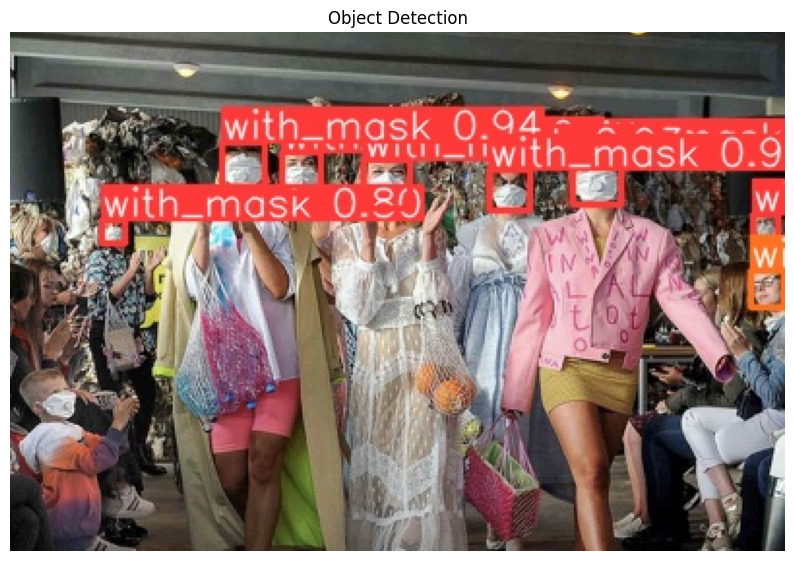

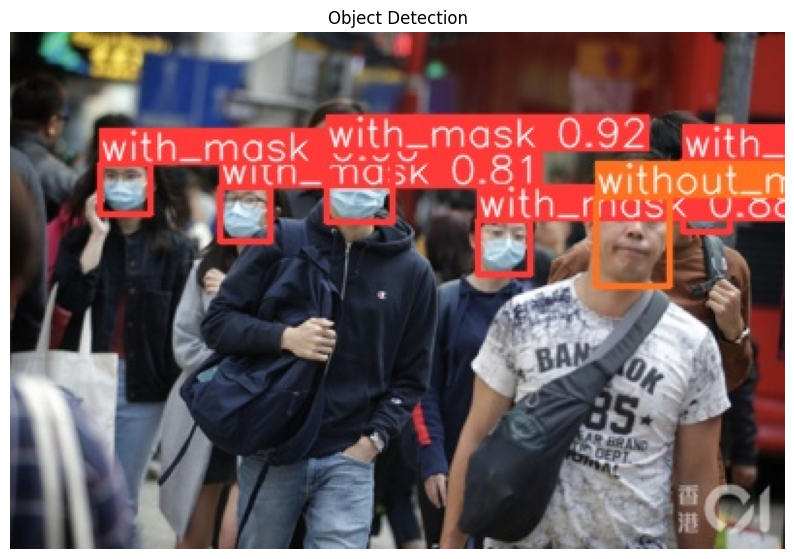

In [26]:
#예측 결과 이미지 불러오기
#커스텀 이미지로 학습후(train) 예측시(predict)시에는 무조건 파일명이 정해져있다.
#이미지명은 image0.jpg,image1.jpg로 등으로 정해져 있다

for index in range(len(images)):  
   
    pred_image = Image.open(os.path.join(results[index].save_dir,f'image{str(index)}.jpg'))
    #이미지 뷰어 윈도우 프로그램에 띄울때
    #pred_image.show()
    #<Figure size 1000x1000 with 1 Axes>만 표시되고 이미지가 안나오는 경우
    %matplotlib inline
    plt.figure(figsize=(10,10))
    plt.imshow(pred_image)
    plt.title("Object Detection")
    plt.axis(False)   
    
plt.show()